In [1528]:
from __future__ import print_function
from pymongo import MongoClient
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
import sys
import os

import jellyfish # library for fuzzy text comparisons
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from tqdm import tqdm_pandas, tqdm_notebook as tqdm
from tqdm import tqdm as tqorig
tqorig.pandas(tqdm)
from autocorrect import spell
from textblob import TextBlob

[nltk_data] Downloading package wordnet to /Users/natali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1529]:
client = MongoClient()
db     = client.fletcher
reviews   = db.reviews

In [1530]:
#cursor = reviews.find()

In [1531]:
cursor = reviews.find({},{ 'text_review Student Support': 1, 'college' : 1, 'text_review Job Prospects': 1, 'text_review Clubs and Societies':1,
                        'Student Support': 1, 'Job Prospects': 1, 'Clubs and Societies':1})

cursor = reviews.find({},{ 'text_review Student Support': 1, 'college' : 1, 'text_review Job Prospects': 1, 'text_review Clubs and Societies':1,
                         'text_review City Life': 1,'text_review Uni Facilities': 1, "text_review Student Support" : 1} )

In [1532]:
df_overall_review = pd.DataFrame(list(cursor))

In [1535]:
len(df_overall_review)*8

691440

In [1536]:
df_overall_review.tail(100)

,Clubs and Societies,Job Prospects,Student Support,_id,college,text_review Clubs and Societies,text_review Job Prospects,text_review Student Support
86330,2.0,3.0,3,5c766b58c0bfe17384c0d1fa,University of Chichester,"it's too far to walk, i'm too tired most of th...",it's a bit too early to tell,Yes
86331,5.0,4.0,4,5c766b58c0bfe17384c0d204,Loughborough University,Good selection,The placement scheme on my course is good,Yes
86332,2.0,3.0,3,5c766b58c0bfe17384c0d20d,University of Chichester,it's hard when i don't live here,NaN,Yes
86333,2.0,4.0,4,5c766b58c0bfe17384c0d217,Loughborough University,I don't really participate because I have othe...,Constant help and support available in this area,Yes
86334,3.0,4.0,5,5c766b58c0bfe17384c0d221,"Teesside University, Middlesbrough",NaN,Amazingly!\nNot only are there plenty of servi...,Yes
86335,2.0,1.0,4,5c766b58c0bfe17384c0d22b,University of Chichester,i'm not in any - i finish uni late on Wednesda...,uni has not provided this?,Yes
86336,2.0,1.0,2,5c766b58c0bfe17384c0d235,University of Chichester,"not in any societies, so feel singled out",uni has not helped me find a job,Yes
86337,4.0,4.0,4,5c766b58c0bfe17384c0d23e,Loughborough University,It's hard to get involved in societies when yo...,Support is on hand,Yes
86338,3.0,3.0,3,5c766b58c0bfe17384c0d248,University of Chichester,lots of clubs and societies. seems like compet...,feel that my course only prepares us for certa...,Yes
86339,4.0,4.0,5,5c766b58c0bfe17384c0d252,Loughborough University,I struggle with knee problems,I feel like I should get a job by the end,Yes


In [1537]:
#df_overall_review['reviews'] = df_overall_review['text_review OVERALL UNIVERSITY RATING']
df_overall_review = df_overall_review.dropna()

In [1539]:
df_overall_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36053 entries, 0 to 86428
Data columns (total 8 columns):
Clubs and Societies                36053 non-null float64
Job Prospects                      36053 non-null float64
Student Support                    36053 non-null int64
_id                                36053 non-null object
college                            36053 non-null object
text_review Clubs and Societies    36053 non-null object
text_review Job Prospects          36053 non-null object
text_review Student Support        36053 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 2.5+ MB


In [1540]:
letters_only = lambda x: re.sub("[^a-zA-Z]", " ", str(x))
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

In [1541]:
df_overall_review.head()

,Clubs and Societies,Job Prospects,Student Support,_id,college,text_review Clubs and Societies,text_review Job Prospects,text_review Student Support
0,3.0,4.0,3,5c75db20c0bfe17384b4d259,"Northumbria University, Newcastle",volunteering,careers weeks and offering placments,good support
1,3.0,4.0,5,5c75db20c0bfe17384b4d262,University of Cumbria,Good,50% of degree is spent on placement,Excellent
2,5.0,3.0,3,5c75db20c0bfe17384b4d26b,"Northumbria University, Newcastle","We have many clubs near to my home, Westgate n...",They guide us through various websites and sha...,"Support is always there, as an International s..."
3,4.0,2.0,1,5c75db20c0bfe17384b4d274,University of Hull,they are well run,they have a careers department that they try t...,never had a ast. its lacking
5,5.0,5.0,5,5c75db20c0bfe17384b4d287,"Northumbria University, Newcastle",There are a great varieties of clubs and socie...,My university provided skills development sect...,The feedback to our works are always helpful a...


In [1542]:
df_overall_review['text_review Student Support'] = df_overall_review['text_review Student Support'].map(letters_only).map(alphanumeric).map(punc_lower)

In [1543]:
df_overall_review['text_review Job Prospects'] = df_overall_review['text_review Job Prospects'].map(letters_only).map(alphanumeric).map(punc_lower)

In [1544]:
df_overall_review['text_review Clubs and Societies'] = df_overall_review['text_review Clubs and Societies'].map(letters_only).map(alphanumeric).map(punc_lower)

In [1545]:
df_overall_review.head()

,Clubs and Societies,Job Prospects,Student Support,_id,college,text_review Clubs and Societies,text_review Job Prospects,text_review Student Support
0,3.0,4.0,3,5c75db20c0bfe17384b4d259,"Northumbria University, Newcastle",volunteering,careers weeks and offering placments,good support
1,3.0,4.0,5,5c75db20c0bfe17384b4d262,University of Cumbria,good,of degree is spent on placement,excellent
2,5.0,3.0,3,5c75db20c0bfe17384b4d26b,"Northumbria University, Newcastle",we have many clubs near to my home westgate n...,they guide us through various websites and sha...,support is always there as an international s...
3,4.0,2.0,1,5c75db20c0bfe17384b4d274,University of Hull,they are well run,they have a careers department that they try t...,never had a ast its lacking
5,5.0,5.0,5,5c75db20c0bfe17384b4d287,"Northumbria University, Newcastle",there are a great varieties of clubs and socie...,my university provided skills development sect...,the feedback to our works are always helpful a...


In [1546]:
sample = df_overall_review[df_overall_review['college'] == 'University of Chichester'][0:200]

In [1547]:
c = sample['Clubs and Societies']
j = sample['Job Prospects']
s = sample['Student Support']

In [1548]:
text = list(sample['text_review Student Support']) + list(sample['text_review Job Prospects']) + list(sample['text_review Clubs and Societies']) 

In [1549]:
text = [item for item in text]

In [1550]:
import sys
if sys.version_info[0] >= 3:
    unicode = str

In [1551]:
news = [' '.join(filter(unicode.isalpha, raw.lower().split())) for raw in
        text]

In [1552]:
news

['good',
 'opportunities for councelling if required has improved this last year compared to my st year as for tutoring it is available however some systems don t always function as smoothly as they could',
 'there are professionals available all the time for both emotional and intellectual support they advertise a lot of counselling online for people to access and look into to make appointments my lecturers are also really good at replying to emails if i need any support within may academic work',
 'excellent lecturers are fantastic and the well being group is amazing',
 'the personal support offered by the uni is amazing a few weeks after starting uni i recieved an email asking me to fill out a survey to ask how i was doing after having said i was feeling quite homesick i got a call the next day asking if i would like to talk to any of the counselling staff about it this uni really does care about the student i cannot praise the lecturers and staff enough for that',
 'teachers are al

In [1553]:
import lda
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 3 # number of topics
n_iter = 500 # number of iterations

# vectorizer: ignore English stopwords & words that occur less than 5 times
cvectorizer = CountVectorizer(min_df=5, stop_words='english')
cvz = cvectorizer.fit_transform(news)

# train an LDA model
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)

INFO:lda:n_documents: 600
INFO:lda:vocab_size: 149
INFO:lda:n_words: 2168
INFO:lda:n_topics: 3
INFO:lda:n_iter: 500
/Users/natali/anaconda3/envs/py37/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.

INFO:lda:<0> log likelihood: -15515
INFO:lda:<10> log likelihood: -11805
INFO:lda:<20> log likelihood: -11569
INFO:lda:<30> log likelihood: -11414
INFO:lda:<40> log likelihood: -11332
INFO:lda:<50> log likelihood: -11300
INFO:lda:<60> log likelihood: -11241
INFO:lda:<70> log likelihood: -11177
INFO:lda:<80> log likelihood: -11138
INFO:lda:<90> log likelihood: -11119
INFO:lda:<100> log likelihood: -11097
INFO:lda:<110> log likelihood: -11050
INFO:lda:<120> log likelihood: -11008
INFO:lda:<130> log likelihood: -10983
INFO:lda:<140> log likelihood: -10911
INFO:lda:<150> log likelihood: -10844
INFO:lda:<160> log likelihoo

In [1554]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

# 2-D
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.003s...
[t-SNE] Computed neighbors for 600 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.834919
[t-SNE] KL divergence after 1000 iterations: -2.204705


In [1555]:
tsne_lda

array([[ 196.40376  ,  -29.79751  ],
       [ 102.3927   ,  150.61699  ],
       [-119.12729  ,  -33.452908 ],
       ...,
       [  53.73953  , -128.3593   ],
       [ 281.27362  ,   -0.3454109],
       [  72.47105  , -139.24812  ]], dtype=float32)

In [1556]:
n_top_words = 3 # number of keywords we show
colormap = np.array(["#1f77b4", 'grey', 'teal'])

In [1557]:
_lda_keys = []
for i in range(X_topics.shape[0]):
    _lda_keys += X_topics[i].argmax(),

In [1558]:
topic_summaries = []
topic_word = lda_model.topic_word_  # all topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
    topic_summaries.append(' '.join(topic_words)) # a

In [1559]:
tsne_lda[0, 0], tsne_lda[0, 1]

(196.40376, -29.79751)

In [1560]:
#_lda_keys.replace({0:, 0:1})

In [1561]:
hey = pd.DataFrame({'x' : tsne_lda[:, 0], 'y' :tsne_lda[:, 1], 'key': _lda_keys})

In [1562]:
hey.to_csv('hey.csv')

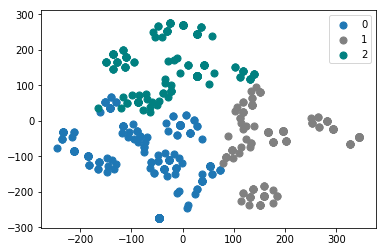

In [1563]:
cdict = {0: "#1f77b4", 1: 'grey', 2: 'teal'}
fig, ax = plt.subplots()
for g in np.unique(_lda_keys):
    ix = np.where(_lda_keys == g)
    ax.scatter(tsne_lda[ix, 0], tsne_lda[ix, 1], c = cdict[g], label = g, s = 50)
ax.legend()
plt.show()

In [1564]:
from sklearn.feature_extraction.text import TfidfTransformer

In [1565]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(news)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [1567]:
sample.head()

,Clubs and Societies,Job Prospects,Student Support,_id,college,text_review Clubs and Societies,text_review Job Prospects,text_review Student Support
5360,5.0,5.0,4,5c75e07fc0bfe17384b58aa5,University of Chichester,good,lots of support in looking and everything with...,good
5808,4.0,3.0,3,5c75e0f0c0bfe17384b59a24,University of Chichester,there is a wide range of clubs and societies ...,they offer frequent job fairs for work opportu...,opportunities for councelling if required has ...
6339,5.0,5.0,5,5c75e177c0bfe17384b5acc1,University of Chichester,i haven t joined any societies but i have hear...,the university is constantly emailing the stud...,there are professionals available all the time...
7060,1.0,5.0,5,5c75e22fc0bfe17384b5c6b4,University of Chichester,never used them,the careers are exceptional as a team and my w...,excellent lecturers are fantastic and the wel...
7080,4.0,5.0,5,5c75e234c0bfe17384b5c76f,University of Chichester,although i personally haven t joined a society...,everything you learn in uni is a transferable ...,the personal support offered by the uni is ama...


In [1568]:
clubs = pd.DataFrame(sample['text_review Clubs and Societies'].reset_index(drop= True))
clubs.columns = ['review']
job = pd.DataFrame(sample['text_review Job Prospects'].reset_index(drop= True))
job.columns = ['review']
st_sup = pd.DataFrame(sample['text_review Student Support'].reset_index(drop= True))
st_sup.columns = ['review']

In [1569]:
reviews = pd.DataFrame(columns = ['review'])

In [1570]:
reviews = reviews.append(clubs)
reviews = reviews.append(job)
reviews = reviews.append(st_sup)

In [1571]:
_lda_keys;

In [1572]:
reviews['label'] = [_lda_keys][0]

In [1573]:
reviews['polarity'] = reviews['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [1574]:
old_min = reviews['polarity'].min()
old_max = reviews['polarity'].max()
range_ = old_max - old_min

In [1575]:
a = list(c)
b = list(j)
c = list(s)

In [1576]:
a.extend(b)
a.extend(c)

In [1577]:
reviews['rating_true'] = a

In [1578]:
reviews['rating_my'] = reviews['polarity'].apply(lambda x: (x - old_min)*4/2 + 1)

In [1591]:
ls = ([0]*200 + [1]*200)

In [1592]:
ls = (ls + [2]*200)

In [1593]:
len(ls)

600

In [1594]:
reviews['label_true'] = ls

In [1595]:
reviews.head(10)

,review,label,polarity,rating_true,rating_my,label_true
0,good,0,0.700000,5.0,4.025000,0
1,there is a wide range of clubs and societies ...,2,-0.012500,4.0,2.600000,0
2,i haven t joined any societies but i have hear...,1,0.350000,5.0,3.325000,0
3,never used them,1,0.000000,1.0,2.625000,0
4,although i personally haven t joined a society...,1,0.125000,4.0,2.875000,0
5,there are quite a lot but my course is very b...,2,0.261667,4.0,3.148333,0
6,limited,1,-0.071429,2.0,2.482143,0
7,societies have plenty of social outings but is...,1,0.033333,3.0,2.691667,0
8,expensive but amazing,1,0.050000,5.0,2.725000,0
9,the majority of societies i have joined are ve...,1,0.200000,4.0,3.025000,0


In [1596]:
import plotly.graph_objs as go

In [1597]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

x = reviews['label']

trace0 = go.Box(
    y=reviews['rating_my'],
    x=x,
    name='Accommodation',
    marker=dict(
        color='grey'
    )
)
data = [trace0]
layout = go.Layout(
    yaxis=dict(
        title='normalized moisture',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)

plot(fig)

In [1598]:
len(reviews)

600

In [1599]:
reviews['label'] = reviews['label'].replace({1:0, 0:1})

To compare with true ratings

In [1600]:
reviews.head()

,review,label,polarity,rating_true,rating_my,label_true
0,good,1,0.7000,5.0,4.025,0
1,there is a wide range of clubs and societies ...,2,-0.0125,4.0,2.600,0
2,i haven t joined any societies but i have hear...,0,0.3500,5.0,3.325,0
3,never used them,0,0.0000,1.0,2.625,0
4,although i personally haven t joined a society...,0,0.1250,4.0,2.875,0


In [1601]:
trace0 = go.Box(
    y=reviews['rating_my'],
    x=reviews['label'],
    name='Users_ratings',
    marker=dict(
        color='grey'
    )
)

trace1 = go.Box(
    y=reviews['rating_my'],
    x=reviews['label_true'],
    name='Model_ratings',
    marker=dict(
        color='teal'
    )
)


data = [trace0, trace1]
layout = go.Layout(
    yaxis=dict(
        title='rating',
        zeroline=False
    ),
    boxmode='group'
)

fig = go.Figure(data=data, layout=layout)

plot(fig)

'file:///Users/natali/Code/Metis/Metis-Bootcamp/projects/04-fletcher/temp-plot.html'

In [1602]:
reviews.groupby('label')['polarity'].mean()

label
0    0.289319
1    0.280208
2    0.200035
Name: polarity, dtype: float64

In [1603]:
topic_summaries

['support good students', 'good societies clubs', 'careers work opportunities']

In [1605]:
_lda_keys;

In [1642]:
def accuracy(_lda_keys):
    zero_class_label = _lda_keys[:201]  #students support class
    first_class_label = _lda_keys[201:401] # career class
    second_class_label = _lda_keys[401:601] #social life class
    count_0 = 0
    
    #class 0 accuracy:

    for item in zero_class_label:
        if item == 0:
            count_0 += 1
    
    count_1 = 0
    for item in first_class_label:
        if item == 2:    #because in topic_summaries carree is the second group 
            count_1 += 1
            
    count_2 = 0
    for item in second_class_label:
        if item == 1:
            count_2 += 1  #because in topic_summaries carree is the first group 
    
    
    return "Acurracy on first group: {}, acurracy on second group: {}, acurracy on third group: {}".format(count_1/len(zero_class_label), count_1/len(first_class_label),count_2/len(second_class_label))
    
    

In [1643]:
accuracy(_lda_keys)

'Acurracy on first group: 0.681592039800995, acurracy on second group: 0.685, acurracy on third group: 0.7336683417085427'